# Super Bowl Strategy

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

import utils

C:\Users\tomw1\AppData\Local\Temp\ipykernel_3456\4289409527.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
MIN_DAYS_HELD = 1
MAX_DAYS_HELD = 25

BUY_N_DAYS_AFTER_SUPER_BOWL = 1

## Rules

The Super Bowl is on the 2nd Sunday in February.

1. Buy day after Super Bowl and Sell n days after.

In [3]:
TICKER = "^GSPC"

### Get Data

In [4]:
# sp500 = yf.download(TICKER, progress=False)[["Adj Close", "Open"]]
sp500 = yf.download(TICKER, progress=False)["Adj Close"]
sp500 = sp500.to_frame(name=TICKER)
sp500.head(5)

C:\Users\tomw1\AppData\Local\pypoetry\Cache\virtualenvs\quantified-strategies-wFBlb7GR-py3.11\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,^GSPC
Date,
1927-12-30,17.660000
1928-01-03,17.760000
1928-01-04,17.719999
1928-01-05,17.549999
1928-01-06,17.660000


### Filter data from first Super Bowl

In [5]:
SUPER_BOWL_DATES = utils.get_super_bowl_dates()
SUPER_BOWL_DATES[:5]

[datetime.date(1967, 1, 15),
 datetime.date(1968, 1, 14),
 datetime.date(1969, 1, 12),
 datetime.date(1970, 1, 11),
 datetime.date(1971, 1, 17)]

In [6]:
SUPER_BOWL_DATE_DICT = {date.year: date for date in SUPER_BOWL_DATES}

### Add all dates

In [7]:
sp500 = sp500.reindex(index=pd.date_range(start=sp500.index[0], end=sp500.index[-1]))

### Get Data from Super Bowl to N-days After

In [8]:
## Extract year from date
sp500["year"] = sp500.index.year

In [9]:
## Map year to Super Bowl date
sp500["date_of_super_bowl"] = sp500["year"].map(SUPER_BOWL_DATE_DICT)
## Remove years which don't have a Super Bowl
sp500 = sp500.loc[~sp500["date_of_super_bowl"].isna()].copy()

In [10]:
## Get days after super bowl
sp500["days_after_super_bowl"] = sp500.apply(lambda x: (x.name.date() - x["date_of_super_bowl"]).days, axis=1)
## Filter on days after super bowl between 0 and 21
sp500 = sp500.loc[(sp500["days_after_super_bowl"] >= BUY_N_DAYS_AFTER_SUPER_BOWL) & (sp500["days_after_super_bowl"] <= 21*2)].copy()
## Filter days out with no data
sp500 = sp500.loc[~sp500.index.weekday.isin([5, 6])]
# Forward Fill Index Values
sp500[TICKER] = sp500.groupby("year")[TICKER].ffill()

### Calculate return day-to-day after Super Bowl

In [11]:
sp500[f"{TICKER}_ret"] = sp500.groupby("year")[TICKER].pct_change()

### Calculate Cumulative Return from Super Bowl to N-days after

In [12]:
sp500[f"{TICKER}_cumret"] = sp500.groupby("year")[f"{TICKER}_ret"].apply(lambda x: (1 + x).cumprod() - 1).reset_index(level=0, drop=True)

In [13]:
sp500 = sp500.loc[(sp500["days_after_super_bowl"] >= MIN_DAYS_HELD) & (sp500["days_after_super_bowl"] <= MAX_DAYS_HELD)]

## Plot Strategy Results of Strategy

In [14]:
mu_ret = sp500.groupby("days_after_super_bowl")[f"{TICKER}_cumret"].mean().dropna()
sig_ret = sp500.groupby("days_after_super_bowl")[f"{TICKER}_cumret"].std().dropna()

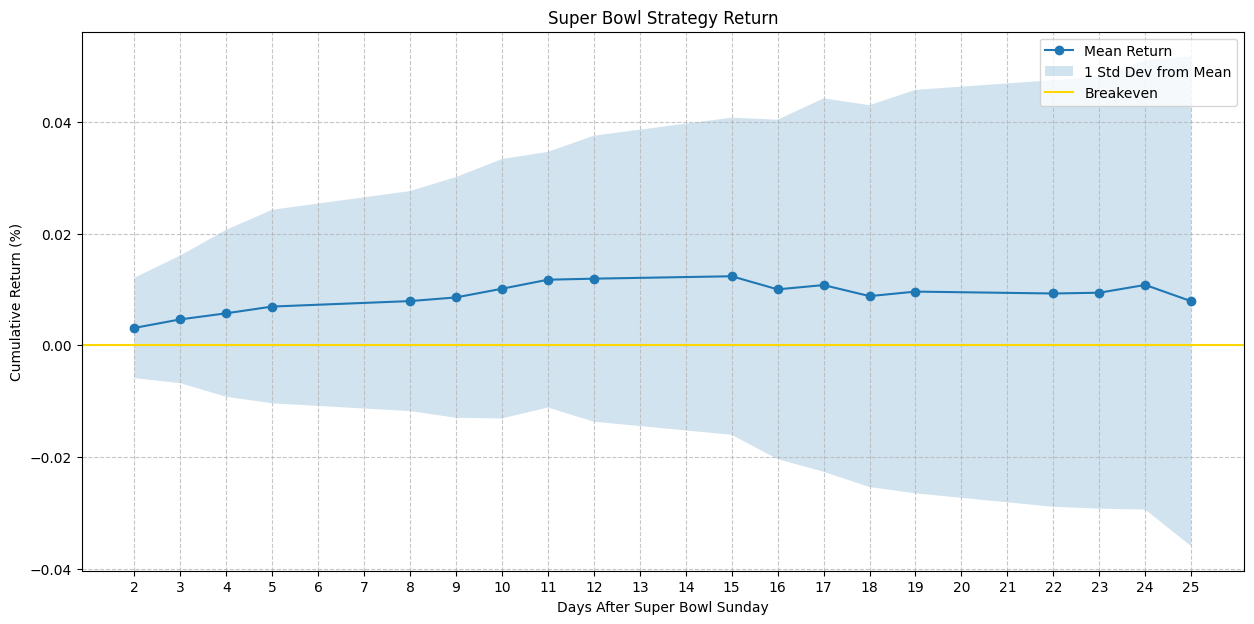

In [15]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(mu_ret, label="Mean Return", marker="o")
ax.fill_between(mu_ret.index.tolist(), mu_ret - sig_ret, mu_ret + sig_ret, alpha=0.2, label="1 Std Dev from Mean")
ax.axhline(y=0, label="Breakeven", color="gold")

ax.legend(loc="best")

plt.xticks(range(min(mu_ret.index), max(mu_ret.index) + 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("Days After Super Bowl Sunday")
plt.ylabel("Cumulative Return (%)")
plt.title("Super Bowl Strategy Return")
plt.show()

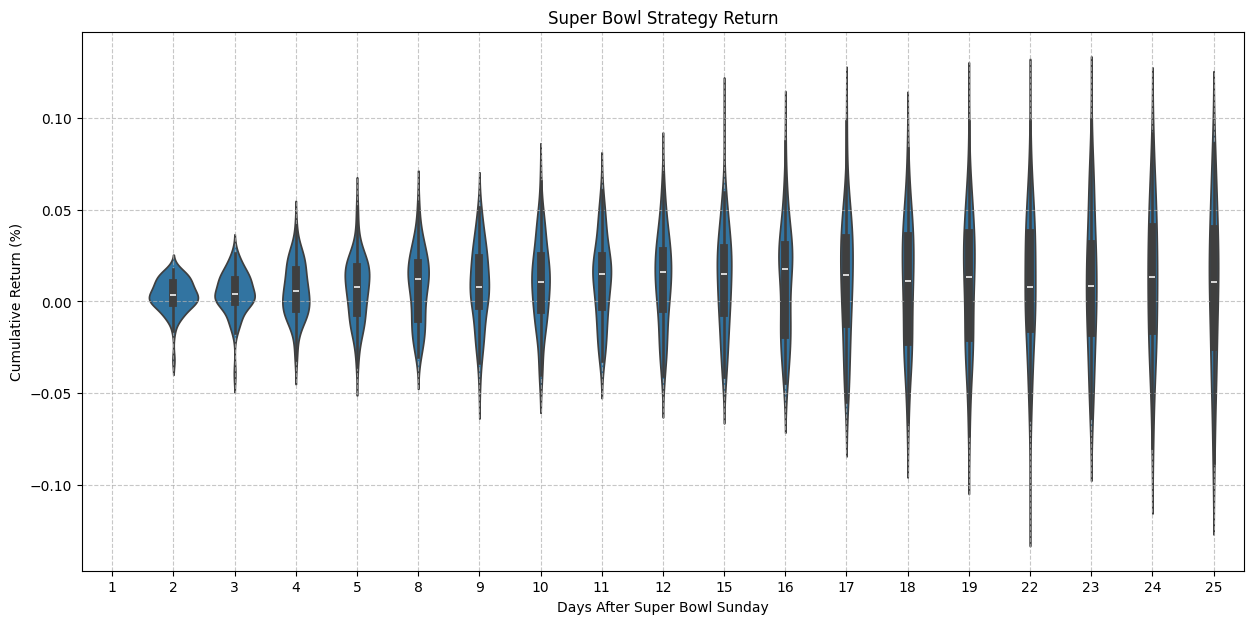

In [16]:

x = "days_after_super_bowl"
y = f"{TICKER}_cumret"

fig, ax = plt.subplots(figsize=(15, 7))

# Create a violin plot
sns.violinplot(x=x, y=y, data=sp500, ax=ax)

# Add labels and title
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("Days After Super Bowl Sunday")
plt.ylabel("Cumulative Return (%)")
plt.title("Super Bowl Strategy Return")

# Show the plot
plt.show()

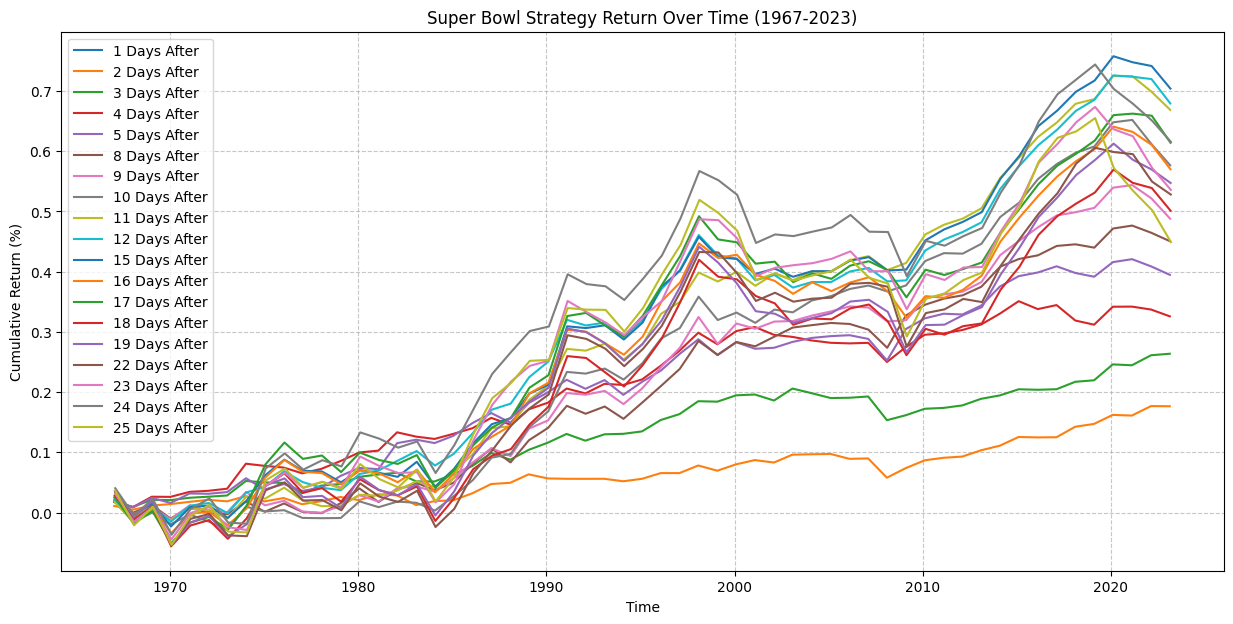

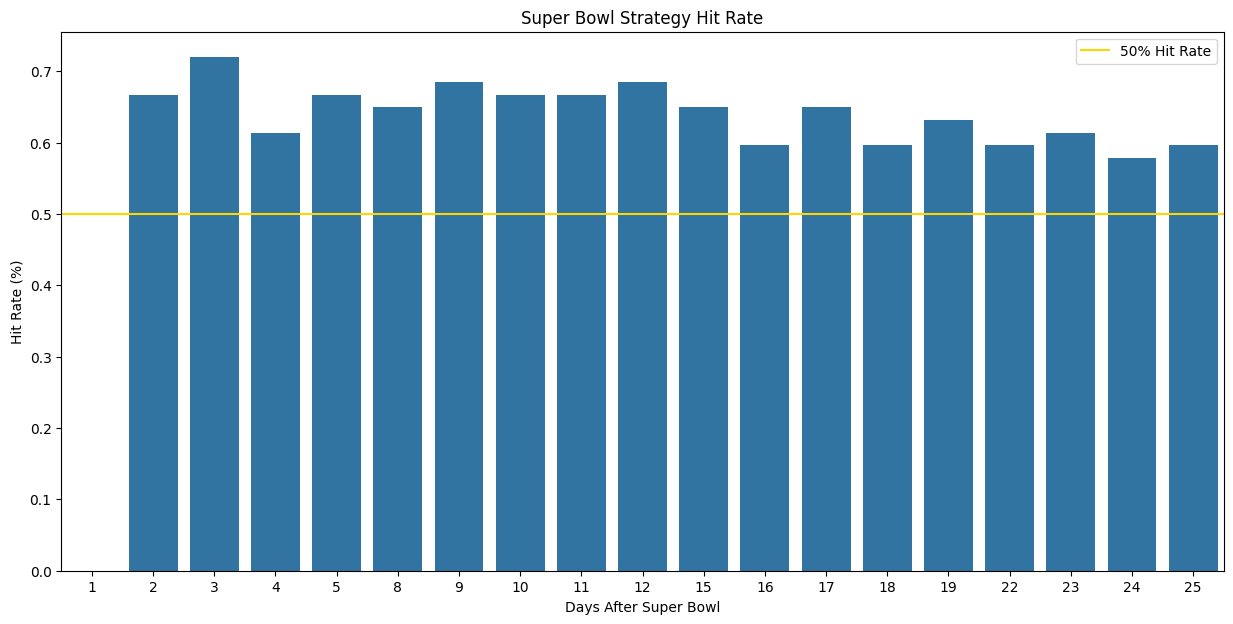

In [17]:
days_after_super_bowl_list = sp500["days_after_super_bowl"].unique().tolist()

fig, ax = plt.subplots(figsize=(15, 7))

for days_after in days_after_super_bowl_list:

    rets = sp500.loc[sp500["days_after_super_bowl"] == days_after, f"{TICKER}_cumret"]
    cum_ret = rets.cumsum()
    
    ax.plot(cum_ret, label=f"{days_after} Days After")
    
ax.legend(loc="best")

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Cumulative Return (%)")
plt.title(f"Super Bowl Strategy Return Over Time ({sp500.index[0].year}-{sp500.index[-1].year})")

plt.show()


fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(sp500.groupby("days_after_super_bowl")[f"{TICKER}_cumret"].apply(lambda x: (x > 0).mean()))
ax.axhline(y=0.5, label="50% Hit Rate", color="gold")
ax.legend(loc="best")
plt.xlabel("Days After Super Bowl")
plt.ylabel("Hit Rate (%)")
plt.title(f"Super Bowl Strategy Hit Rate")
plt.show()


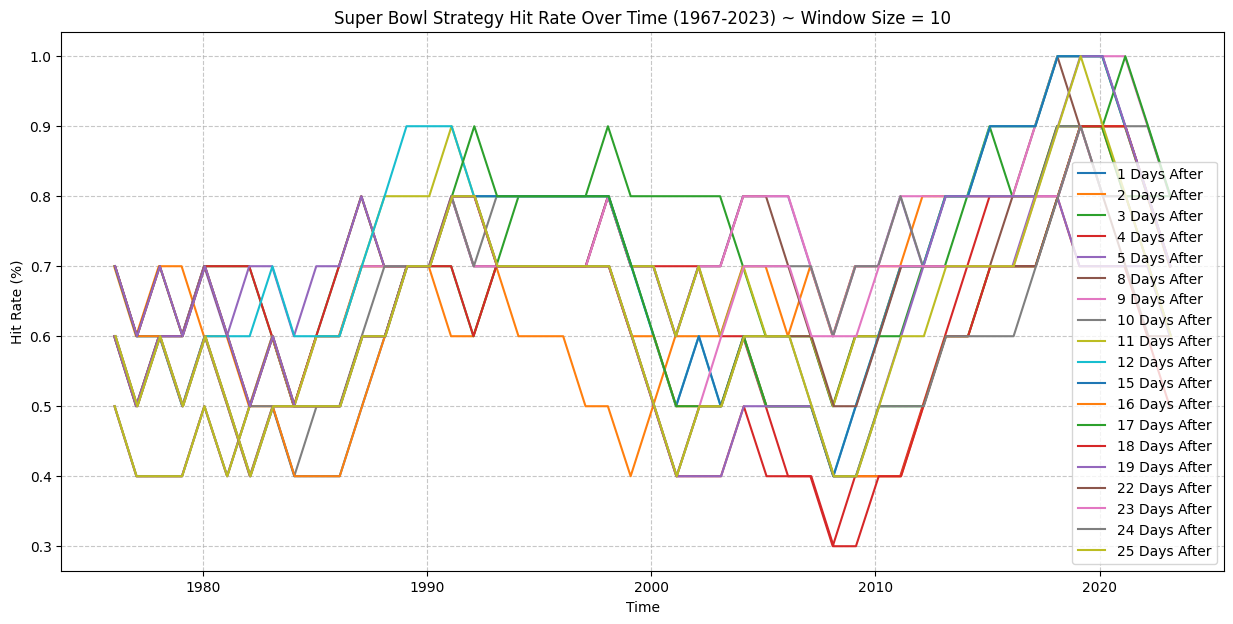

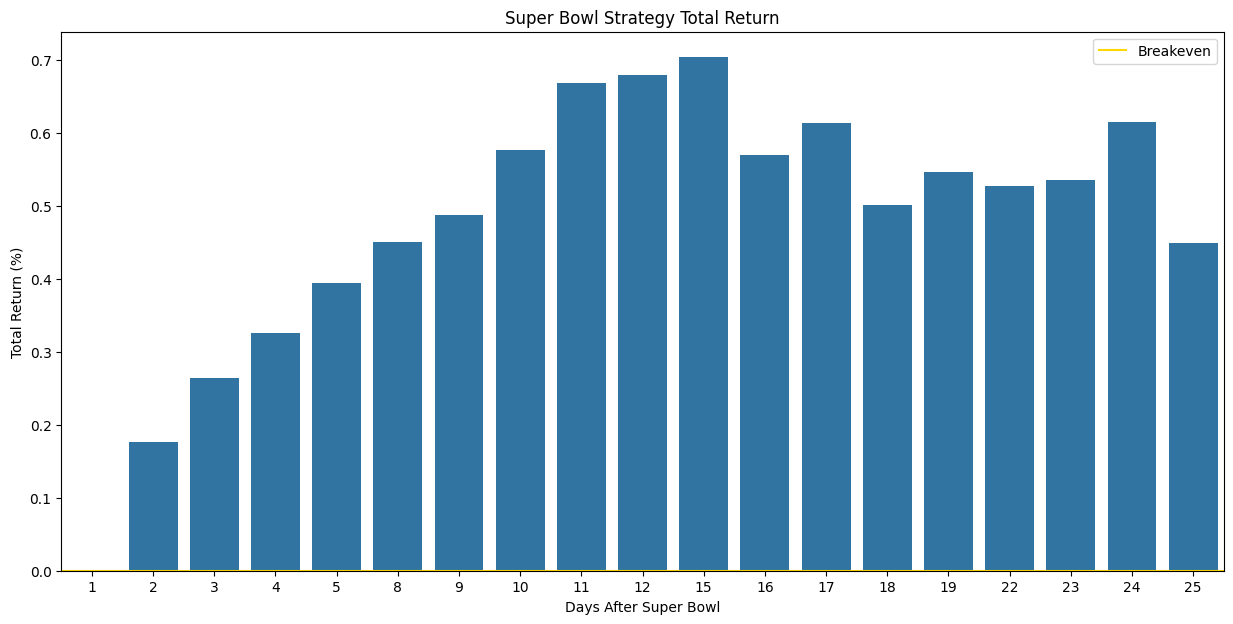

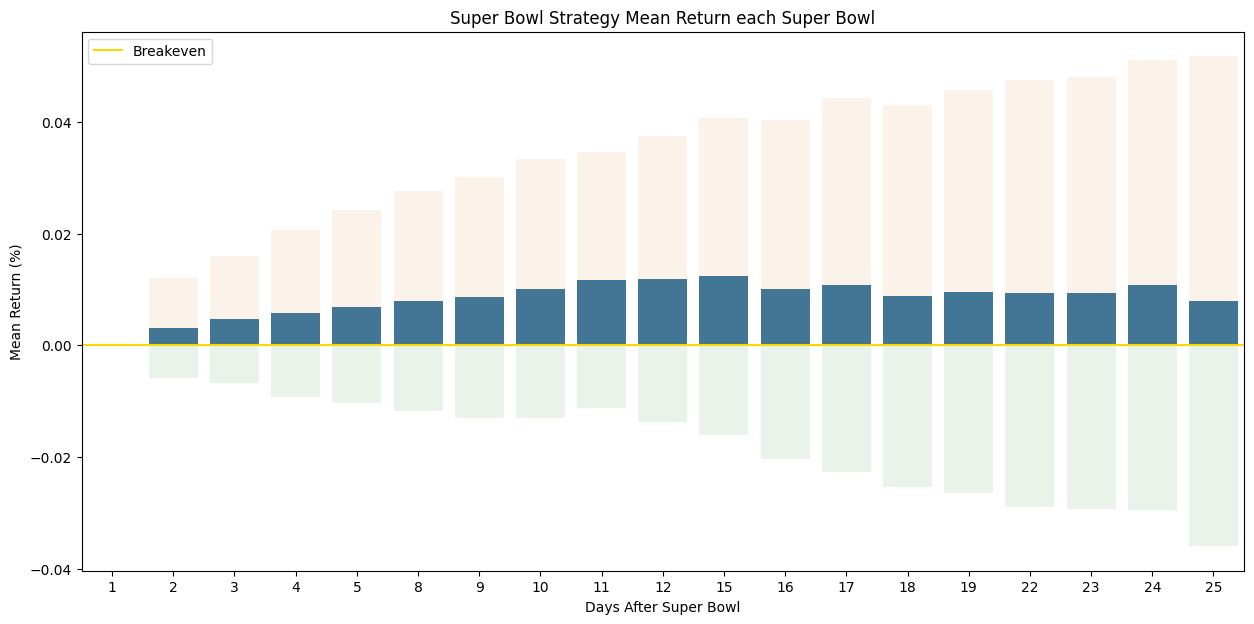

In [29]:
days_after_super_bowl_list = sp500["days_after_super_bowl"].unique().tolist()

# ROLLING HIT RATE

fig, ax = plt.subplots(figsize=(15, 7))

for days_after in days_after_super_bowl_list:

    rets = sp500.loc[sp500["days_after_super_bowl"] == days_after, f"{TICKER}_cumret"]
    ax.plot(rets.rolling(window=10).apply(lambda x: (x > 0).mean()), label=f"{days_after} Days After")
    
ax.legend(loc="best")

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Hit Rate (%)")
plt.title(f"Super Bowl Strategy Hit Rate Over Time ({sp500.index[0].year}-{sp500.index[-1].year}) ~ Window Size = 10")

plt.show()


fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(sp500.groupby("days_after_super_bowl")[f"{TICKER}_cumret"].sum())
ax.axhline(y=0.0, label="Breakeven", color="gold")
ax.legend(loc="best")
plt.xlabel("Days After Super Bowl")
plt.ylabel("Total Return (%)")
plt.title(f"Super Bowl Strategy Total Return")
plt.show()


mu = sp500.groupby("days_after_super_bowl")[f"{TICKER}_cumret"].mean()
sig = sp500.groupby("days_after_super_bowl")[f"{TICKER}_cumret"].std()
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(mu)
sns.barplot(mu+sig, alpha=0.1)
sns.barplot(mu-sig, alpha=0.1)
ax.axhline(y=0.0, label="Breakeven", color="gold")
ax.legend(loc="best")
plt.xlabel("Days After Super Bowl")
plt.ylabel("Mean Return (%)")
plt.title(f"Super Bowl Strategy Mean Return each Super Bowl")
plt.show()


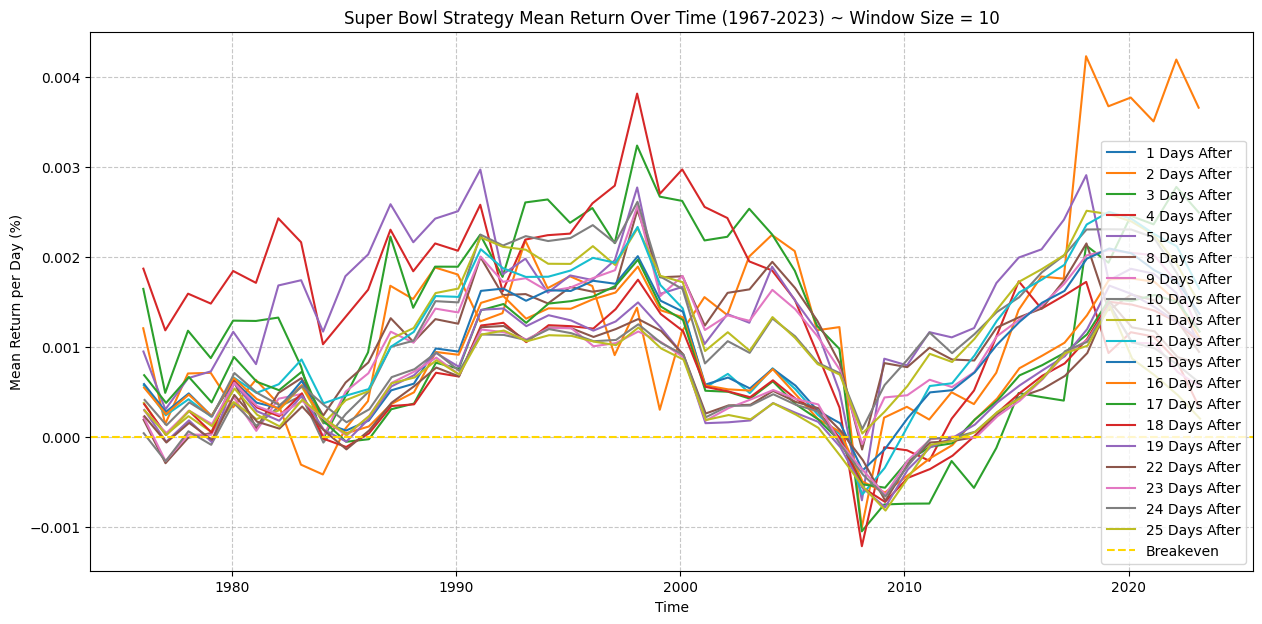

In [19]:
WINDOW_SIZE = 10

days_after_super_bowl_list = sp500["days_after_super_bowl"].unique().tolist()

fig, ax = plt.subplots(figsize=(15, 7))

for days_after in days_after_super_bowl_list:

    rets = sp500.loc[sp500["days_after_super_bowl"] == days_after, f"{TICKER}_cumret"]
    ax.plot(rets.rolling(window=WINDOW_SIZE).mean() / days_after, label=f"{days_after} Days After")

ax.axhline(y=0, label="Breakeven", color="gold", linestyle="--")
ax.legend(loc="best")

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Mean Return per Day (%)")
plt.title(f"Super Bowl Strategy Mean Return Over Time ({sp500.index[0].year}-{sp500.index[-1].year}) ~ Window Size = {WINDOW_SIZE}")

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


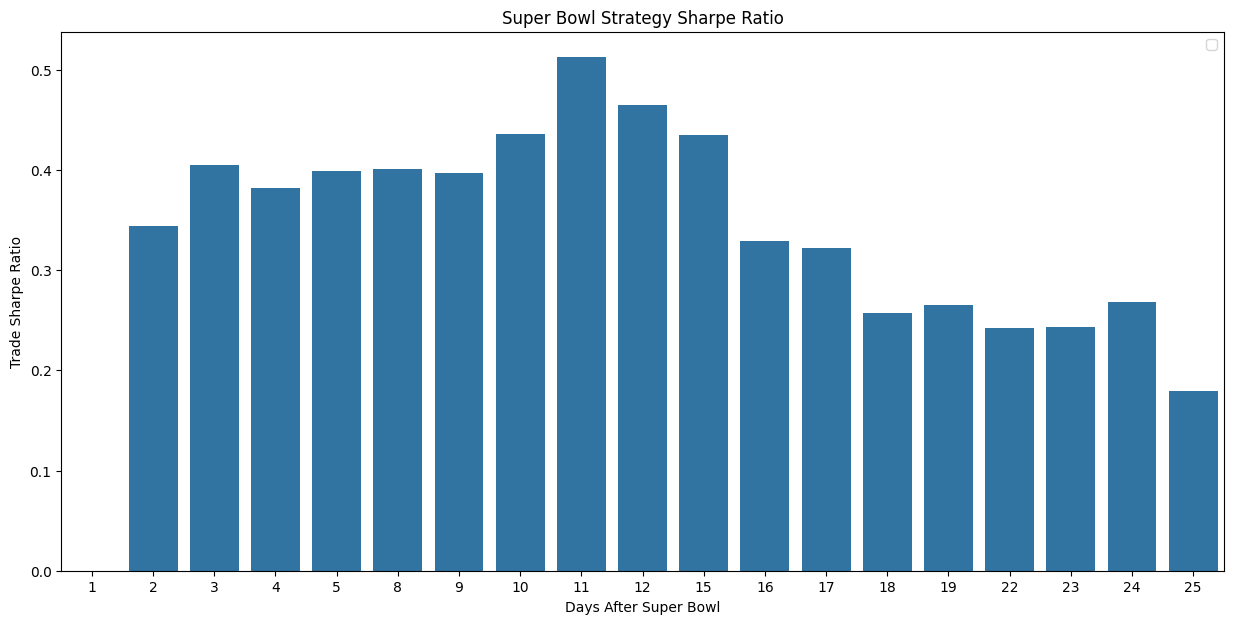

In [20]:

fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(sp500.groupby("days_after_super_bowl")[f"{TICKER}_cumret"].apply(lambda x: x.mean() / x.std()))
ax.legend(loc="best")
plt.xlabel("Days After Super Bowl")
plt.ylabel("Trade Sharpe Ratio")
plt.title(f"Super Bowl Strategy Sharpe Ratio")
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


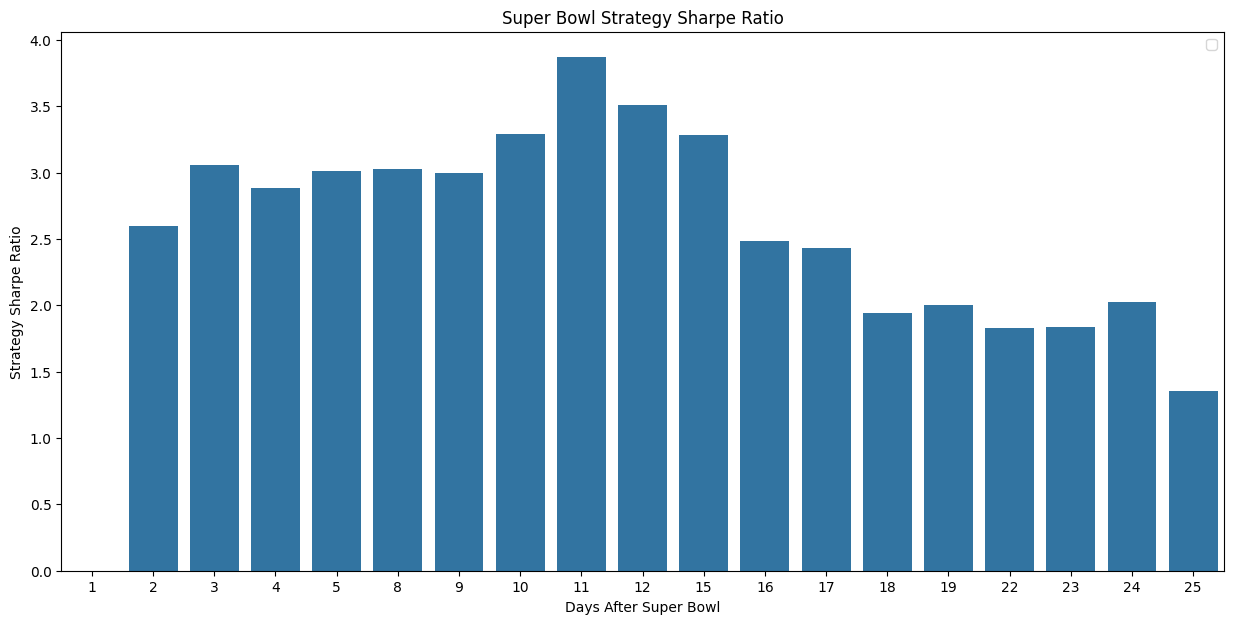

In [21]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(sp500.groupby("days_after_super_bowl")[f"{TICKER}_cumret"].apply(lambda x: x.mean() / x.std() * np.sqrt(x.shape[0])))
ax.legend(loc="best")
plt.xlabel("Days After Super Bowl")
plt.ylabel("Strategy Sharpe Ratio")
plt.title(f"Super Bowl Strategy Sharpe Ratio")
plt.show()

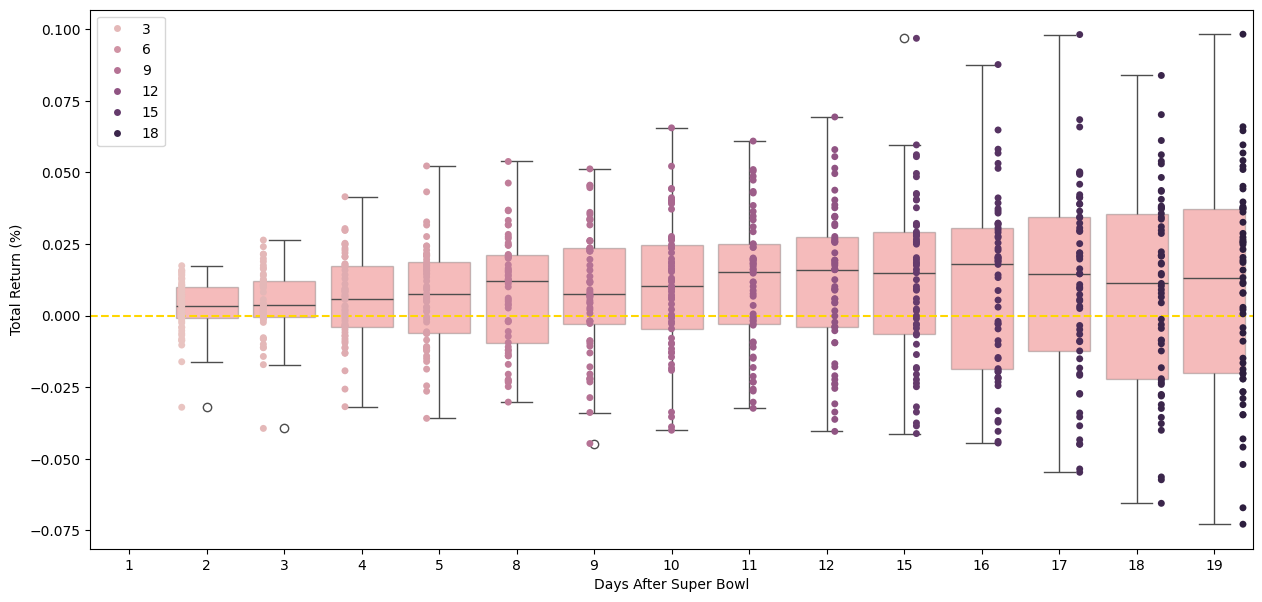

In [49]:
HOLD_LENGTH = 20

fig, ax = plt.subplots(figsize=(15, 7))

sns.stripplot(
    data=sp500.loc[sp500["days_after_super_bowl"] <= HOLD_LENGTH], 
    x="days_after_super_bowl", 
    y=f"{TICKER}_cumret", 
    hue="days_after_super_bowl",
    dodge=True, jitter=False,
    ax=ax,
)
sns.boxplot(x="days_after_super_bowl", y=f"{TICKER}_cumret", data=sp500.loc[sp500["days_after_super_bowl"] <= HOLD_LENGTH], color='red', boxprops=dict(alpha=0.3))

ax.axhline(y=0, color="gold", label="Breakeven", linestyle="--")

plt.xlabel("Days After Super Bowl")
plt.ylabel("Total Return (%)")

plt.show()
